In [6]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *
from multioutput_rbf_linear_gp import *


import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
import os
import torch
import gpytorch
import datetime
import seaborn as sns


# sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


## Load Data

The cell below loads in AIS traectories from a specified date range and processes them to form a regression dataset. Modify the start and end date in date_range as desired, but leave the frequency at 'D'.

NOTE: The dataset class does not currently handle the download of the daily csv data. Users should download the desired date range by using the cli as specified in the README.

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_07.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3850/3850 [00:01<00:00, 2468.77it/s]



===== Dataset Statistics =====
Total number of AIS messages: 4335092
Number of unique MMSIs: 3850
Date range: 2024-01-01 00:00:00 to 2024-01-02 23:59:59
Number of vessel groups: 9


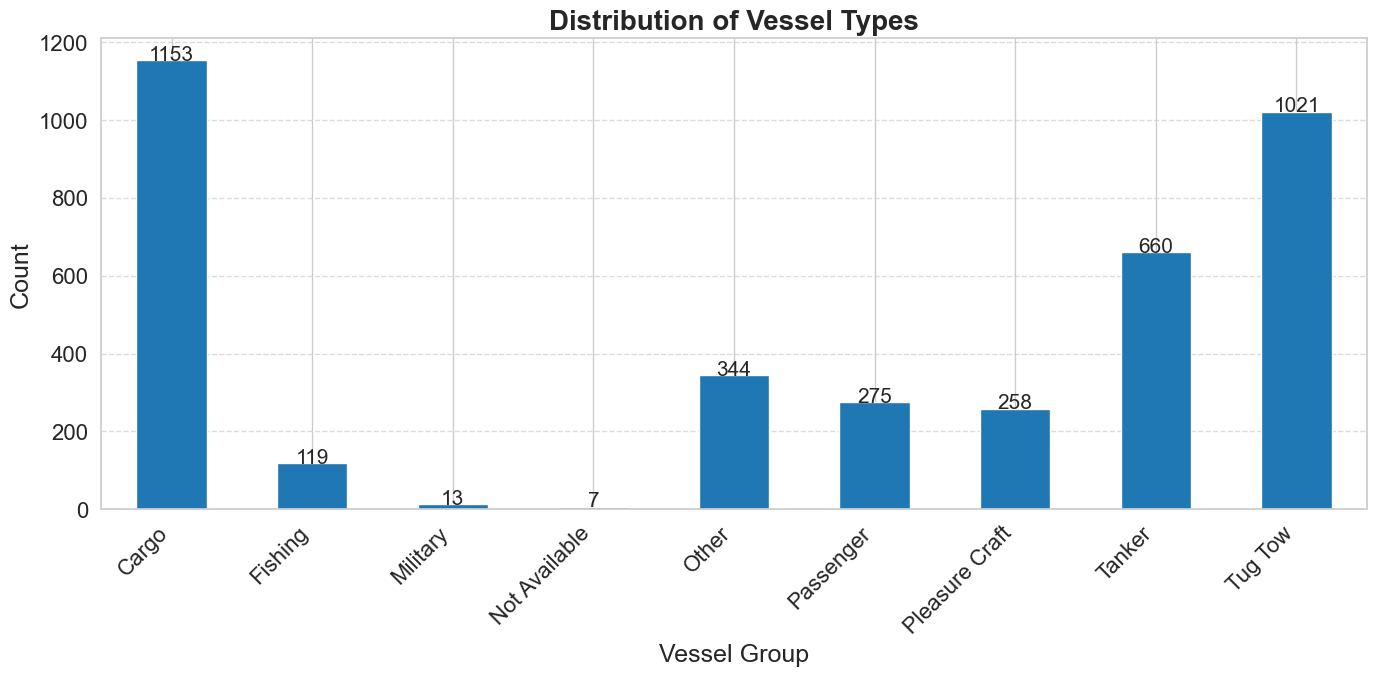

In [7]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-07', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# Display vessel group histogram
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

## Fit GP Models

Using the specified date_range in the cell above for forming the gp_regression_dataset, we 

In [8]:
# Control flag - set to True to load existing models if available, False to force retraining
reload_existing_models = True

# Load or train models using our modular functions
models, likelihoods, losses = load_or_train_models(date_range, gp_regression_dataset, device, reload_existing_models)

print(f"Successfully loaded/trained {len(models)} models for {len(gp_regression_dataset)} trajectories")

No exact match found for date range 2024-01-01_to_2024-01-07. Looking for partial date bundles...
Loading models from rbf_and_linear_kernel_classification_bundle_2024-01-01_n1100.pt


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### View the kernel parameters of the first model

These are the learned kernel parameters from maximizing the marginal log likelihood in the Gaussian Process Regression.

In [9]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
# print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

NameError: name 'models' is not defined

### Plot GP Solution

In [ ]:
# import ipywidgets as widgets
# from IPython.display import display, clear_output
# from plotting_utils import *


def plot_for_mmsi(selected_mmsi):
    plt.close('all')
    clear_output(wait=True)
    model = models[selected_mmsi]
    likelihood = likelihoods[selected_mmsi]
    # Get the corresponding data for this MMSI
    times, state_trajectory = None, None
    for entry in gp_regression_dataset:
        if entry[0] == selected_mmsi:
            _, times, state_trajectory = entry
            break
    if times is None:
        print("No data for MMSI:", selected_mmsi)
        return

    train_X = times.clone().detach().unsqueeze(1).cpu()
    train_Y = state_trajectory.clone().detach().cpu()
    test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
    test_Y = eval_model(model, likelihood, test_X)

    plot_gp(train_X, train_Y, test_X, test_Y)
    plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu())

    
mmsi_dropdown = widgets.Dropdown(
    options=list(models.keys()),
    description='MMSI:',
    disabled=False,
)

widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    

NameError: name 'models' is not defined

## Create the kernel param to ship mmsi dataset


In [ ]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

num_params = len(kernel_classification_dataset.get_parameter_names())

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

In [ ]:
# print(num_params)
input_dim = kernel_classification_dataset.data[0][1].shape[0]
print(input_dim)

56


## Train the classification model

In [ ]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=input_dim, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=1000)

GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


Test Accuracy: 0.3169


<Figure size 1000x800 with 0 Axes>

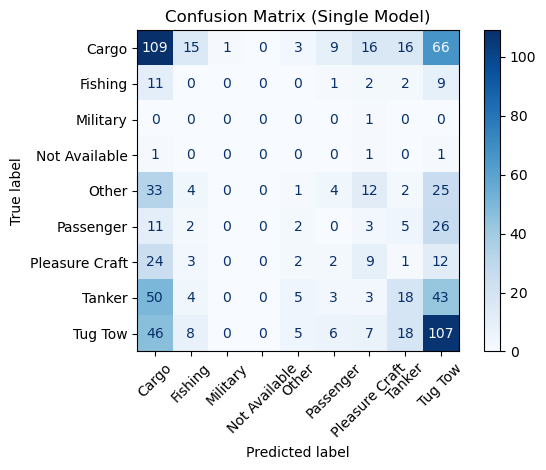

In [ ]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

## 5-Fold Cross Validation Classification Predictions

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure k-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics across folds
all_preds = []
all_labels = []
fold_accuracies = []

# Get all indices
dataset_size = len(kernel_classification_dataset)
indices = list(range(dataset_size))

print(f"Starting {k_folds}-fold cross validation on {dataset_size} samples")

# K-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create data samplers for train and test
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=512, 
        sampler=train_sampler
    )
    test_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=512,
        sampler=test_sampler
    )
    
    # Get the input dimension from the dataset
    input_dim = kernel_classification_dataset.data[0][1].shape[0]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model, loss function, and optimizer
    model = GPKernelShipClassificationNetwork(
        input_dim=input_dim, 
        num_classes=max(unique_group_ids) + 1
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    
    # Train the model
    trainer = GPKernelShipClassificationTrainer(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    trainer.train(num_epochs=5000)  # Reduced epochs for quicker k-fold demo
    
    # Evaluate on the test set
    fold_preds = []
    fold_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            mmsi, X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            fold_preds.extend(preds)
            fold_labels.extend(y.cpu().numpy())
    
    # Calculate fold accuracy
    fold_accuracy = np.mean(np.array(fold_preds) == np.array(fold_labels))
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
    
    # Add to overall results
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

# Calculate and display overall metrics
print("\n==== Cross-Validation Results ====")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Get unique classes that are actually present in the predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))

# Create class labels only for classes present in the data
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Generate and plot the aggregate confusion matrix with proper class labels
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(14, 12))



Starting 5-fold cross validation on 3850 samples

Fold 1/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:46<00:00, 46.77it/s]


Fold 1 Accuracy: 0.3481

Fold 2/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:42<00:00, 48.83it/s]


Fold 2 Accuracy: 0.3571

Fold 3/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:30<00:00, 55.05it/s]


Fold 3 Accuracy: 0.3584

Fold 4/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:30<00:00, 55.22it/s]


Fold 4 Accuracy: 0.4026

Fold 5/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:32<00:00, 53.78it/s]

Fold 5 Accuracy: 0.3792

==== Cross-Validation Results ====
Mean Accuracy: 0.3691 ± 0.0196


<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

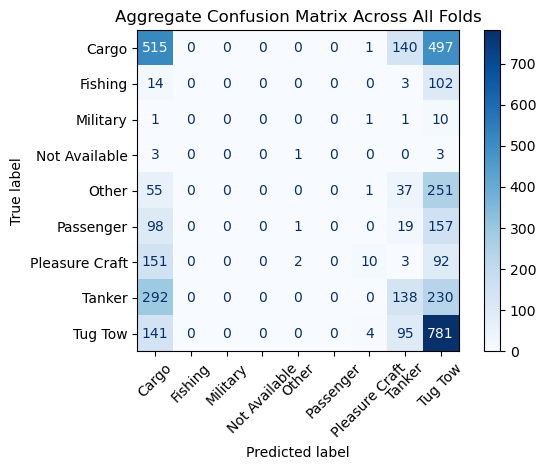


Classification Report:
                precision    recall  f1-score   support

         Cargo       0.41      0.45      0.43      1153
       Fishing       0.00      0.00      0.00       119
      Military       0.00      0.00      0.00        13
 Not Available       0.00      0.00      0.00         7
         Other       0.00      0.00      0.00       344
     Passenger       0.00      0.00      0.00       275
Pleasure Craft       0.59      0.04      0.07       258
        Tanker       0.32      0.21      0.25       660
       Tug Tow       0.37      0.76      0.50      1021

      accuracy                           0.38      3850
     macro avg       0.19      0.16      0.14      3850
  weighted avg       0.31      0.38      0.31      3850


Class Distribution in Dataset:
Cargo: 1153 samples
Fishing: 119 samples
Military: 13 samples
Not Available: 7 samples
Other: 344 samples
Passenger: 275 samples
Pleasure Craft: 258 samples
Tanker: 660 samples
Tug Tow: 1021 samples


/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:

sns.reset_orig() 
# Create the confusion matrix with class names that match the matrix dimensions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues', xticks_rotation=45)  # Rotate labels for better readability
plt.title('Aggregate Confusion Matrix Across All Folds')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Generate classification report with descriptive class names
print("\nClassification Report:")
target_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]
print(classification_report(all_labels, all_preds, labels=unique_present_classes, target_names=target_names))

# Print class distribution
print("\nClass Distribution in Dataset:")
class_counts = {}
for label in all_labels:
    class_name = id_to_vessel_group.get(label, f"Unknown ({label})")
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} samples")


In [ ]:
def run_trajectory_ablation_study(models, gp_regression_dataset, device, 
                                  trajectory_counts=[10, 100, 500, 1000, 3850],
                                  num_trials=3, epochs=100, seed=42):
    """
    Run an ablation study on how the number of trajectories affects classification accuracy,
    using consistent class counts across all trajectory sizes.
    """
    import numpy as np
    import torch
    import random
    from sklearn.metrics import accuracy_score
    from torch.utils.data import random_split
    import matplotlib.pyplot as plt
    
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Results storage
    results = {
        'trajectories': trajectory_counts,
        'accuracies': [],
        'std_devs': []
    }
    
    # Full model count
    total_models = len(models)
    print(f"Total available models: {total_models}")
    
    # Ensure trajectory counts are sorted
    trajectory_counts = sorted(trajectory_counts)
    max_count = trajectory_counts[-1]
    
    if max_count > total_models:
        print(f"Warning: Requested {max_count} trajectories but only have {total_models}")
        max_count = total_models
        
    # Track accuracies for each count and trial
    all_accuracies = {count: [] for count in trajectory_counts}
    
    # First determine the classes present in the largest dataset
    # This ensures all models are trained with the same number of classes
    print("\nCreating full dataset to determine class structure...")
    all_mmsis = list(models.keys())
    full_sampled_mmsis = random.sample(all_mmsis, max_count)
    full_sampled_models = {mmsi: models[mmsi] for mmsi in full_sampled_mmsis}
    
    full_dataset = GPKernelShipClassificationDataset(
        gp_regression_dataset, 
        full_sampled_models,
        device,
        scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi
    )
    
    # Get the full set of classes we need to predict across all trajectories
    all_unique_groups = full_dataset.get_unique_group_ids()
    num_classes = max(all_unique_groups) + 1
    
    print(f"Using consistent class count: {len(all_unique_groups)} classes (0-{max(all_unique_groups)})\n")
    
    # Run multiple trials
    for trial in range(num_trials):
        print(f"\n==== Trial {trial+1}/{num_trials} ====")
        
        # Randomly sample the maximum number of models needed
        sampled_mmsis = random.sample(all_mmsis, max_count)
        
        # For each trajectory count (in ascending order)
        for count in trajectory_counts:
            # Take only the first 'count' models for this iteration
            current_mmsis = sampled_mmsis[:count]
            sampled_models = {mmsi: models[mmsi] for mmsi in current_mmsis}
            
            print(f"  Testing with {count} trajectories")
            kernel_dataset = GPKernelShipClassificationDataset(
                gp_regression_dataset, 
                sampled_models,
                device,
                scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi
            )
            
            # Get actual classes in this dataset (for logging purposes)
            dataset_unique_groups = kernel_dataset.get_unique_group_ids()
            print(f"    Number of samples: {len(kernel_dataset)}")
            print(f"    Actual classes in this subset: {len(dataset_unique_groups)}")
            print(f"    Total classes to predict: {len(all_unique_groups)}")
            
            # Split dataset
            train_size = int(0.8 * len(kernel_dataset))
            test_size = len(kernel_dataset) - train_size
            train_dataset, test_dataset = random_split(kernel_dataset, [train_size, test_size])
            
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)
            
            # Create and train model with the full class count
            input_dim = kernel_dataset.data[0][1].shape[0]
            model = GPKernelShipClassificationNetwork(
                input_dim=input_dim, 
                num_classes=num_classes  # Use consistent class count
            ).to(device)
            
            # Handle class imbalance with weighted loss
            if len(all_unique_groups) > 1:
                class_counts = {}
                for _, _, label in kernel_dataset.data:
                    # Handle both tensor and integer labels
                    if hasattr(label, 'item'):
                        label_idx = label.item()
                    else:
                        label_idx = int(label)
                    
                    class_counts[label_idx] = class_counts.get(label_idx, 0) + 1
                
                weights = []
                total_samples = len(kernel_dataset)
                for i in range(num_classes):
                    if i in class_counts and class_counts[i] > 0:
                        weights.append(total_samples / (len(class_counts) * class_counts[i]))
                    else:
                        weights.append(1.0)  # Weight for classes not in this subset
                
                class_weights = torch.tensor(weights, dtype=torch.float).to(device)
                criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
            else:
                criterion = torch.nn.CrossEntropyLoss()
            
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train
            trainer = GPKernelShipClassificationTrainer(
                model, train_loader, test_loader, criterion, optimizer, device
            )
            trainer.train(num_epochs=epochs)
            
            # Evaluate
            test_preds, test_labels = [], []
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    mmsi, X, y = batch
                    X, y = X.to(device), y.to(device)
                    outputs = model(X)
                    preds = outputs.argmax(dim=1).cpu().numpy()
                    test_preds.extend(preds)
                    test_labels.extend(y.cpu().numpy())
            
            test_acc = accuracy_score(test_labels, test_preds) * 100  # Convert to percentage
            print(f"    Test accuracy: {test_acc:.2f}%")
            all_accuracies[count].append(test_acc)
    
    # Calculate statistics for each trajectory count
    for count in trajectory_counts:
        mean_acc = np.mean(all_accuracies[count])
        std_acc = np.std(all_accuracies[count])
        results['accuracies'].append(mean_acc)
        results['std_devs'].append(std_acc)
        print(f"Average accuracy for {count} trajectories: {mean_acc:.2f}% ± {std_acc:.2f}%")

    # Create plot and display results
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        results['trajectories'], 
        results['accuracies'], 
        yerr=results['std_devs'], 
        fmt='o-', 
        capsize=5, 
        elinewidth=1.2, 
        markerfacecolor='blue'
    )
    
    plt.xlabel("Number of Trained Trajectories")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Classification Test Accuracy vs. Number of Trained Trajectories")
    plt.grid(True)
    
    # Use log scale if range is large
    if max(results['trajectories']) / min(results['trajectories']) > 10:
        plt.xscale('log')
        plt.xticks(results['trajectories'], labels=[str(n) for n in results['trajectories']])
    
    plt.tight_layout()
    plt.show()
    
    # Print results table
    print("\n===== Results =====")
    print(f"{'Trajectories':<15} {'Accuracy (%)':<15} {'Std Dev':<10}")
    print("-" * 40)
    for i, count in enumerate(results['trajectories']):
        print(f"{count:<15} {results['accuracies'][i]:.2f}%{' ':<8} {results['std_devs'][i]:.2f}%")
    
    return results

Total available models: 3850

Creating full dataset to determine class structure...
Using consistent class count: 9 classes (0-8)


==== Trial 1/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 85.15it/s] 


    Test accuracy: 10.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 94.15it/s] 


    Test accuracy: 14.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:08<00:00, 58.69it/s]


    Test accuracy: 12.00%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:19<00:00, 25.68it/s]


    Test accuracy: 29.74%

==== Trial 2/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 102.82it/s]


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 107.08it/s]


    Test accuracy: 16.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 93.96it/s] 


    Test accuracy: 16.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


    Test accuracy: 31.17%

==== Trial 3/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 96.32it/s] 


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 146.73it/s]


    Test accuracy: 20.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 115.32it/s]


    Test accuracy: 15.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:23<00:00, 21.66it/s]


    Test accuracy: 19.74%

==== Trial 4/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 156.65it/s]


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 156.91it/s]


    Test accuracy: 17.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 115.39it/s]


    Test accuracy: 18.00%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:24<00:00, 20.31it/s]


    Test accuracy: 30.26%

==== Trial 5/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 87.06it/s] 


    Test accuracy: 10.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 143.39it/s]


    Test accuracy: 12.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:06<00:00, 82.41it/s]


    Test accuracy: 13.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:14<00:00, 34.04it/s]


    Test accuracy: 34.81%
Average accuracy for 100 trajectories: 13.00% ± 2.45%
Average accuracy for 500 trajectories: 15.80% ± 2.71%
Average accuracy for 1000 trajectories: 15.10% ± 2.13%
Average accuracy for 3850 trajectories: 29.14% ± 5.02%


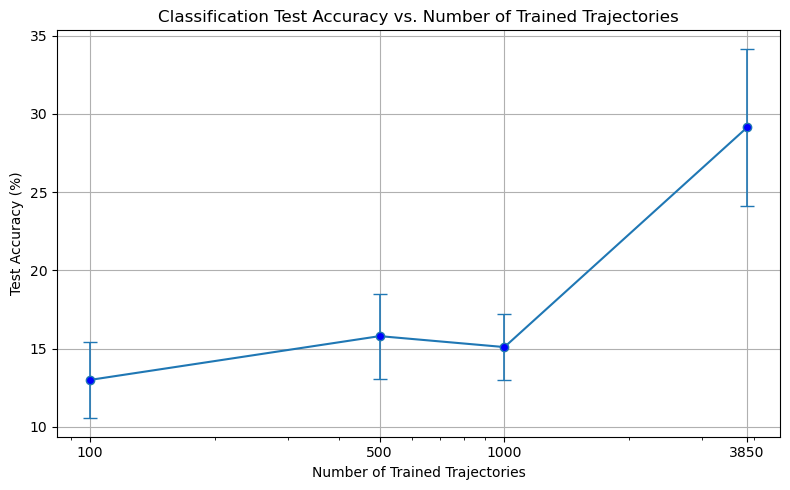


===== Results =====
Trajectories    Accuracy (%)    Std Dev   
----------------------------------------
100             13.00%         2.45%
500             15.80%         2.71%
1000            15.10%         2.13%
3850            29.14%         5.02%


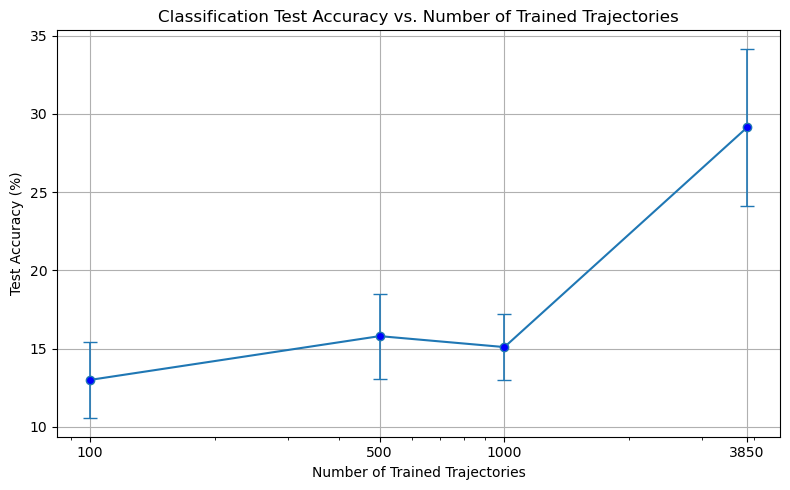

In [ ]:
ablation_results = run_trajectory_ablation_study(
    models=models,
    gp_regression_dataset=gp_regression_dataset,
    device=device,
    trajectory_counts=[100, 500, 1000, 3850],  # Adjust based on # of available models
    num_trials=5,  # Increase for more reliable statistics
    epochs=500     # Training epochs per model
)



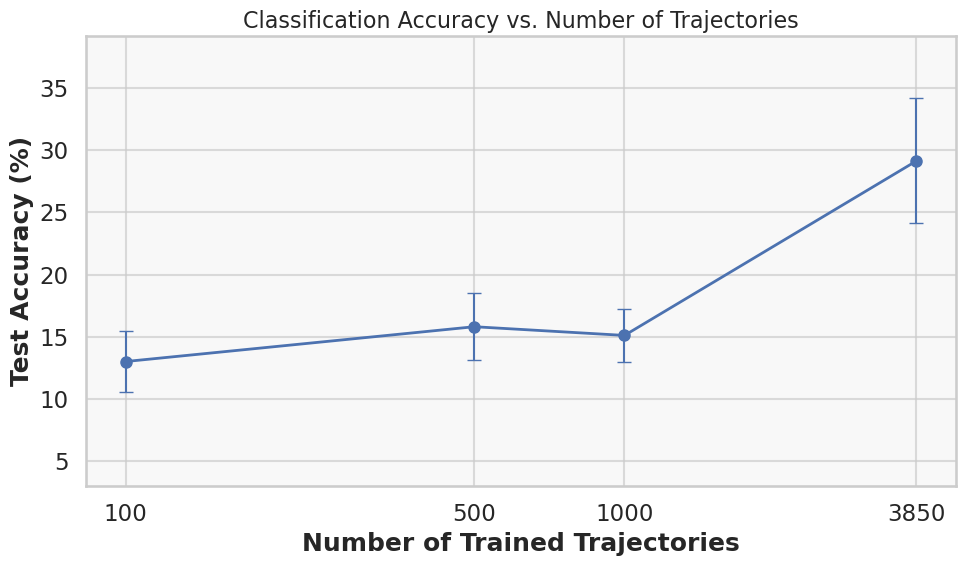

In [ ]:
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid", context="talk")  # Options: whitegrid, darkgrid, white, dark, ticks
# Use a pleasing color palette
palette = sns.color_palette("deep")

trajectories = ablation_results['trajectories']
accuracy = ablation_results['accuracies']
std_dev = ablation_results['std_devs']

plt.figure(figsize=(10, 6))
plt.errorbar(
    trajectories, 
    accuracy, 
    yerr=std_dev, 
    fmt='o-', 
    capsize=5, 
    elinewidth=1.5, 
    markerfacecolor=palette[0],
    color=palette[0],
    markersize=8,
    linewidth=2
)

plt.xlabel("Number of Trained Trajectories", fontweight='bold')
plt.ylabel("Test Accuracy (%)", fontweight='bold')
plt.title("Classification Accuracy vs. Number of Trajectories", fontsize=16)
plt.grid(True, alpha=0.7)
plt.xscale('log')  # Makes it easier to visualize large range
plt.xticks(trajectories, labels=[str(n) for n in trajectories])

# Add min/max y-axis padding for better visualization
y_min = max(0, min(accuracy) - max(std_dev) - 5)
y_max = min(100, max(accuracy) + max(std_dev) + 5)
plt.ylim(y_min, y_max)

# Add a subtle background color
plt.gca().set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()